# Import library

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os

from tensorflow import keras
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow

print("\u2023 Using TensorFlow Version:", tf.__version__)
print(
    "\u2023 GPU Device Found."
    if tf.test.is_gpu_available()
    else "\u2023 GPU Device Not Found. Running on CPU"
)

2024-10-11 15:07:46.922269: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 15:07:46.925307: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 15:07:46.933430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 15:07:46.947242: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 15:07:46.951116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 15:07:46.961235: I tensorflow/core/platform/cpu_feature_gu

‣ Using TensorFlow Version: 2.17.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
‣ GPU Device Not Found. Running on CPU


I0000 00:00:1728634069.094639   25660 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-11 15:07:49.095320: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Data Processing

In [2]:
dataset_dir=r'Rahman2020'


filepaths=[]
labels=[]
classlist=os.listdir(dataset_dir)

for classs in classlist:
    classpath=os.path.join(dataset_dir,classs)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(classs)

file_series= pd.Series(filepaths, name='filepaths')
label_series=pd.Series(labels, name='labels')
df=pd.concat([file_series, label_series], axis=1)

print (df['labels'].value_counts())

labels
Neck_Blast           286
Healthy_Plant        244
Sheath_Blight_Rot    219
Stemborer            201
BLB                  138
Brown_Spot           111
False_Smut            93
Hispa                 73
BPH                   71
Name: count, dtype: int64


In [3]:
train_split=.8
test_split=.1

dummy_split=test_split/(1-train_split)
train_dataframe, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_dataframe, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train data frame len: ', len(train_dataframe), '  test data frame len: ', len(test_dataframe), '  valid data frame len: ', len(valid_df))

train data frame len:  1148   test data frame len:  144   valid data frame len:  144


In [4]:
# Set image dimensions and batch size
height = 224
width = 224
channels = 3
batch_size = 64

img_shape = (height, width, channels)
img_size = (height, width)

# Calculate test batch size and steps
length = len(test_dataframe)
test_batch_size = sorted([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)
print('test batch size:', test_batch_size, '  test steps:', test_steps)


test batch size: 72   test steps: 2


In [5]:
# Create ImageDataGenerators
gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_gen = gen.flow_from_dataframe(
    train_dataframe,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,

)

valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = gen.flow_from_dataframe(
    test_dataframe,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

Found 1148 validated image filenames belonging to 9 classes.
Found 144 validated image filenames belonging to 9 classes.
Found 144 validated image filenames belonging to 9 classes.


In [6]:
# Get class labels
classes = list(train_gen.class_indices.keys())
print(classes)
# print class
class_indices = train_gen.class_indices
class_count = len(classes)
print("Number of classes: ",class_indices)

['BLB', 'BPH', 'Brown_Spot', 'False_Smut', 'Healthy_Plant', 'Hispa', 'Neck_Blast', 'Sheath_Blight_Rot', 'Stemborer']
Number of classes:  {'BLB': 0, 'BPH': 1, 'Brown_Spot': 2, 'False_Smut': 3, 'Healthy_Plant': 4, 'Hispa': 5, 'Neck_Blast': 6, 'Sheath_Blight_Rot': 7, 'Stemborer': 8}


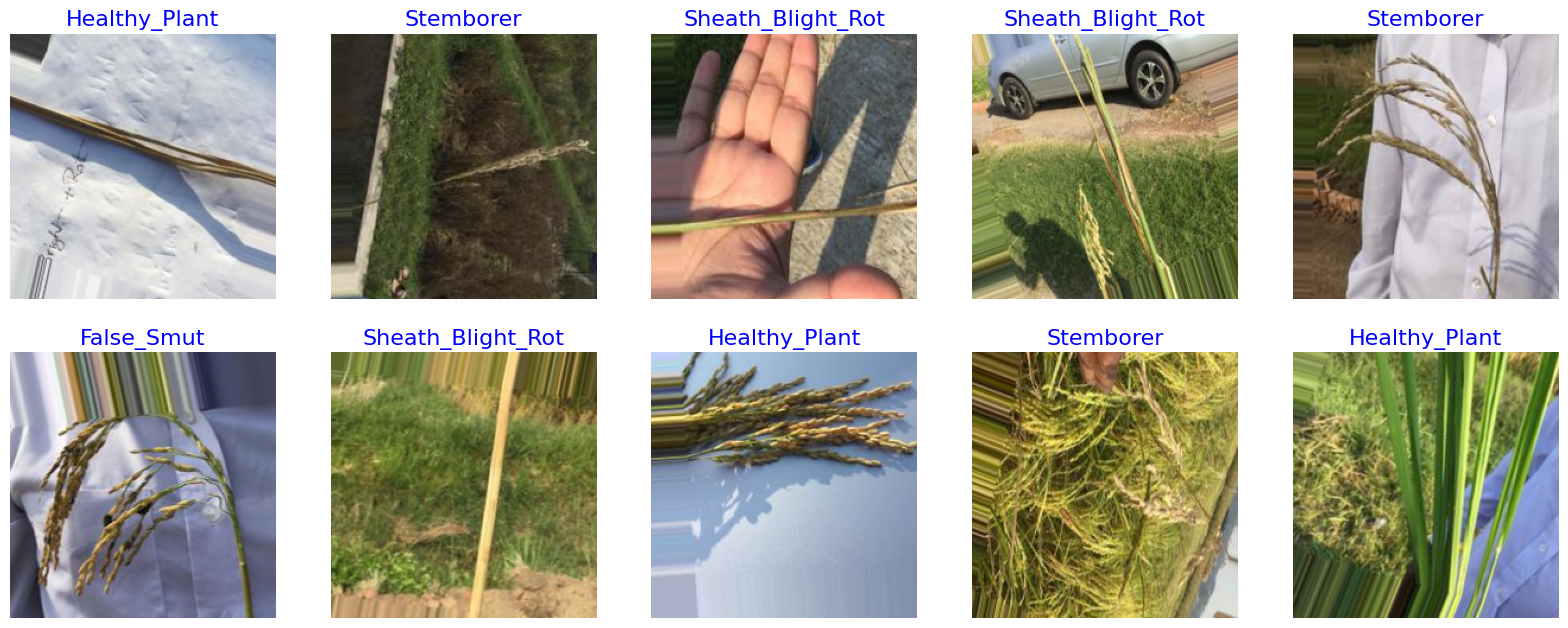

In [7]:
def show_image_samples(gen):
    test_dict = test_gen.class_indices
    classes = list(test_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 10:
        r = length
    else:
        r = 10
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

# Example usage
show_image_samples(test_gen)


# Configuration Transfer Learning

In [23]:
height = 224
width = 224
channels = 3

# Transfer Learning MobileNetV2
TL_model = tf.keras.applications.MobileNetV2(
    input_shape=(height, width, channels),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=tf.keras.layers.Input(shape=(height, width, channels)),
    pooling=None,
)

In [24]:
TL_model.trainable = False

## Training

In [26]:
model_name = 'tes1'
print("Building model with", TL_model)
model = tf.keras.Sequential([
    TL_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation='softmax')
])

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Building model with <Functional name=mobilenetv2_1.00_224, built=True>


In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(
    x=train_gen,
    epochs=30,
    validation_data=valid_gen,
    callbacks=[early_stopping]
)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.2905 - loss: 2.1854 - val_accuracy: 0.4028 - val_loss: 1.5376
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.4712 - loss: 1.4805 - val_accuracy: 0.6111 - val_loss: 1.1949
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5871 - loss: 1.2161 - val_accuracy: 0.6875 - val_loss: 0.9893
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6575 - loss: 0.9901 - val_accuracy: 0.6806 - val_loss: 0.8972
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7125 - loss: 0.8841 - val_accuracy: 0.7569 - val_loss: 0.7796
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7290 - loss: 0.7854 - val_accuracy: 0.7569 - val_loss: 0.7295
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7731 - loss: 0.7334 - val_accuracy: 0.7639 - val_loss: 0.6439
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7853 - loss: 0.6434 - val_accuracy: 0.7847 - val_loss:

# Saved model

# Test

In [30]:
# Simpan model sebagai file h5
model.save('tess1.h5')


In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np

# Mapping kelas
class_mapping = {'BLB': 0, 'BPH': 1, 'Brown_Spot': 2, 'False_Smut': 3, 'Healthy_Plant': 4, 'Hispa': 5, 'Neck_Blast': 6, 'Sheath_Blight_Rot': 7, 'Stemborer': 8}
# Fungsi untuk memprediksi gambar
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = list(class_mapping.keys())[list(class_mapping.values()).index(predicted_class_index)]
    confidence = predictions[0][predicted_class_index]

    return predicted_class, confidence

# Load model
model = tf.keras.models.load_model('tess1.h5')

# Contoh pengujian dengan gambar
image_path = 'Rahman2020/Hispa/Hispa1_6762607a-47e0-4b30-b9f8-a5c4191e6612.jpeg'
predicted_class, confidence = predict_image(model, image_path)

# Output hasil prediksi
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
Predicted Class: Healthy_Plant
Confidence: 0.71986294
